In [4]:
import numpy as np
import tvm
from tvm import te

# Broadcast
广播（broadcast）用于处理不同shape之间的操作。通常, 其中一个操作数的某个维度为1, 沿着另一个操作数的相应维度广播以执行给定的计算。标量运算通常都支持广播
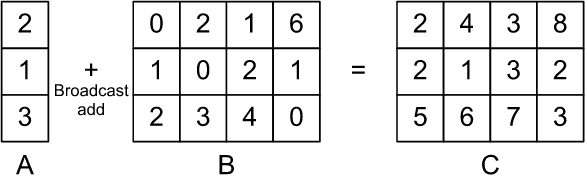

In [29]:
def broadcast_add(shape1, shape2):
    A = te.placeholder(shape1, name='A')
    B = te.placeholder(shape2, name='B')
    m = shape1[0] if shape2[0] == 1 else shape2[0]
    n = shape1[1] if shape2[1] == 1 else shape2[1]
    f = lambda x, y: A[0 if shape1[0]==1 else x, 0 if shape1[1]==1 else y] + \
        B[0 if shape2[0]==1 else x, 0 if shape2[1]==1 else y]
    C = te.compute((m, n), f)
    s = te.create_schedule(C.op)
    print(tvm.lower(s, [A, B, C], simple_mode=True))
    return tvm.build(s, [A, B, C])

op = broadcast_add([3, 1], [3, 4])
a = tvm.nd.array(np.array([[2], [1], [3]], dtype='float32'))
b = tvm.nd.array(np.array([[0, 2, 1, 6], [1, 0, 2, 1], [2, 3, 4, 0]], dtype='float32'))
c = tvm.nd.array(np.empty((3, 4), dtype='float32'))
op(a, b, c)
print('a', a, '\nb', b, '\nc', c)

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [3], []),
             B: Buffer(B_2: Pointer(float32), float32, [12], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [12], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [3, 1], []), B_1: B_3: Buffer(B_2, float32, [3, 4], []), compute_1: compute_3: Buffer(compute_2, float32, [3, 4], [])} {
  for (x: int32, 0, 3) {
    for (y: int32, 0, 4) {
      let cse_var_1: int32 = ((x*4) + y)
      compute[cse_var_1] = (A[x] + B[cse_var_1])
    }
  }
}


a [[2.]
 [1.]
 [3.]] 
b [[0. 2. 1. 6.]
 [1. 0. 2. 1.]
 [2. 3. 4. 0.]] 
c [[2. 4. 3. 8.]
 [2. 1. 3. 2.]
 [5. 6. 7. 3.]]


In [36]:
op = broadcast_add([3, 1], [1, 4])
a = tvm.nd.array(np.array([[2], [1], [3]], dtype='float32'))
b = tvm.nd.array(np.array([[3, 4, 0, 1]], dtype='float32'))
c = tvm.nd.array(np.empty((3, 4), dtype='float32'))
op(a, b, c)
print('a', a, '\nb', b, '\nc', c)

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [3], []),
             B: Buffer(B_2: Pointer(float32), float32, [4], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [12], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [3, 1], []), B_1: B_3: Buffer(B_2, float32, [1, 4], []), compute_1: compute_3: Buffer(compute_2, float32, [3, 4], [])} {
  for (x: int32, 0, 3) {
    for (y: int32, 0, 4) {
      compute[((x*4) + y)] = (A[x] + B[y])
    }
  }
}


a [[2.]
 [1.]
 [3.]] 
b [[3. 4. 0. 1.]] 
c [[5. 6. 2. 3.]
 [4. 5. 1. 2.]
 [6. 7. 3. 4.]]


# Matmul Multiplication
矩阵乘在深度学习中非常常见，有些时候也叫GEMM (GEneral Matrix Multiply)。矩阵乘法的计算如下图所示
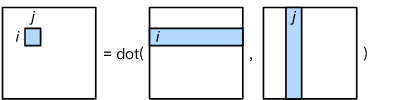

In [45]:
def matmul():
    m, n, l = te.var('m'), te.var('n'), te.var('l')
    A = te.placeholder((m, l), name='A')
    B = te.placeholder((l, n), name='B')
    k = te.reduce_axis((0, l), name='k')
    C = te.compute((m, n), lambda i, j: (te.sum(A[i, k] * B[k, j], axis=k)))
    s = te.create_schedule(C.op)
    print(tvm.lower(s, [A, B, C], simple_mode=True))
    return tvm.build(s, [A, B, C])

op = matmul()
a = tvm.nd.array(np.arange(9).reshape(3, 3).astype('float32'))
b = tvm.nd.array(np.arange(6).reshape(3, 2).astype('float32'))
c = tvm.nd.array(np.empty((3, 2), dtype='float32'))
op(a, b, c)
print('a', a, '\nb', b, '\nc', c)

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [(stride: int32*m: int32)], [], type="auto"),
             B: Buffer(B_2: Pointer(float32), float32, [(stride_1: int32*l: int32)], [], type="auto"),
             compute: Buffer(compute_2: Pointer(float32), float32, [(stride_2: int32*m)], [], type="auto")}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [m, l], [stride, stride_3: int32], type="auto"), B_1: B_3: Buffer(B_2, float32, [l, n: int32], [stride_1, stride_4: int32], type="auto"), compute_1: compute_3: Buffer(compute_2, float32, [m, n], [stride_2, stride_5: int32], type="auto")} {
  for (i: int32, 0, m) {
    for (j: int32, 0, n) {
      compute[((i*stride_2) + (j*stride_5))] = 0f32
      for (k: int32, 0, l) {
        compute[((i*stride_2) + (j*stride_5))] =

# Convolution
卷积运算是许多深度学习模型中常见的运算，关于卷积的介绍可以参考[常见网络层](https://github.com/5million/DeepLearningCompilation/blob/main/model/operation/convolution/Conv.md)
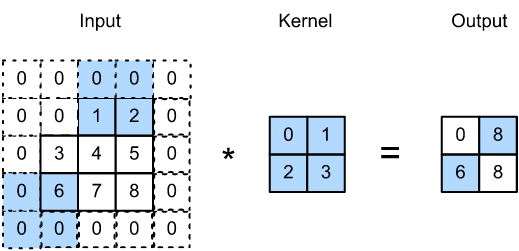

In [ ]:
def convolution(fmap_shape, kernel_shape, padding, strides):
    batch, ci, hi, wi = fmap_shape
    co, _, kh, kw = kernel_shape
    padt, padb, padl, padr = padding
    _, _, sh, sw = strides
    ho = (hi + padt + padb - kh) // sh + 1
    wo = (wi + padl + padr - kw) // sw + 1
    fmap = te.placeholder((batch, ci, hi, wi), name='fmap')
    kernel = te.placeholder((co, co, kh, kw), name='kernel')
    f = lambda i, j, k, l: fmap[]
    